In [5]:
# from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy
# from pywt import wavedec, dwt_max_level, Wavelet, threshold, waverec
import pywt
import skimage
import cv2

In [6]:
img = skimage.io.imread('dataset\cameraman.tif')
img_float = skimage.util.img_as_float32(img)
img.shape
# img_float = np.array(img).astype(np.float64)

(512, 512)

In [7]:
# Add Noise Function
def addGaussianNoise(image, mean = 0, sigma = 15):        
    var = (sigma / 255) ** 2
    noisy_img = skimage.util.random_noise(image, mode='gaussian', mean = mean, var = var)
    return noisy_img

def add_salt_and_pepper_noise(image, amount = 0.05):      
    noisy_img = skimage.util.random_noise(image, mode='s&p', amount=amount)
    return noisy_img

# uniform NOISE

# Master Noise Function
def addNoise(image, mode = 'gaussian', mean = 0, sigma = 15, amount = 0.05):
    if image is not None:
        if mode == 'gaussian':
            return addGaussianNoise(image, mean, sigma)
        elif mode == 's&p':
            return add_salt_and_pepper_noise(image, amount)
    return image

In [8]:
#Threshold
def applyThreshold(coeffs, threshold):
    return np.sign(coeffs) * np.maximum(np.abs(coeffs) - threshold, 0)

In [9]:
# Estimated Noise Standard Deviation
def get_sigma_est(coeffs_list):
    """Estimates noise standard deviation from the HH1 sub-band."""
    hh1 = coeffs_list[-1][2] # HH1 band
    median_hh1 = np.median(np.abs(hh1))
    if median_hh1 == 0: 
        return 0.0001 # Avoid division by zero
    sigma_est = median_hh1 / 0.6745
    return sigma_est

In [54]:
# THRESHOLDING METHODS
def get_visushrink_threshold(N, sigma_est):       
    # Calculate the threshold
    threshold = sigma_est * np.sqrt(2 * np.log(N))
    return threshold

def get_sureshrink_threshold(subband_coeffs, sigma_est):
    """
    Calculates the optimal threshold for a *single* sub-band
    using Stein's Unbiased Risk Estimate (SURE).
    
    Args:
        subband_coeffs: The 2D array of wavelet coefficients for one sub-band.
        sigma: The estimated noise standard deviation (from HH1).
    """
    if sigma_est == 0: return 0 # No noise, no threshold
    
    n = subband_coeffs.size
    if n == 0: return 0
    
    # Rescale coefficients by sigma for SURE calculation (assumes sigma=1)
    y = subband_coeffs.ravel() / sigma_est
    
    # 1. Get the sorted absolute values
    y_abs = np.abs(y)
    y_abs_sorted = np.sort(y_abs)
    y_sq = y_abs_sorted**2
    
    # --- CORRECTED RISK CALCULATION ---
    # This is the correct vectorized formula for SURE(T)
    # risk = n - 2*count(|y|<=T) + sum(min(y^2, T^2))
    
    # For a threshold T = y_abs_sorted[k]:
    
    # term 'count(|y|<=T)' is (k+1)
    term2 = 2 * np.arange(1, n + 1)
    
    # 'cumsum_y_sq[k]' is sum(y_sq[i] for i <= k)
    cumsum_y_sq = np.cumsum(y_sq)
    
    # 'sum(min(y^2, T^2))' is cumsum_y_sq[k] + y_sq[k] * (n - (k+1))
    term1 = cumsum_y_sq + y_sq * np.arange(n - 1, -1, -1)
    
    risk_values = n - term2 + term1
    # --- END CORRECTION ---

    # 3. Find the minimum risk
    best_risk_index = np.argmin(risk_values)
    
    # The threshold that gave this minimum risk
    T_sure = y_abs_sorted[best_risk_index]
    
    # 4. Implement the "Hybrid" rule (this part was correct)
    T_univ = np.sqrt(2 * np.log(n)) # On the rescaled data
    
    eta = np.mean(np.maximum(0, y_sq - 1)**2)
    magic_val = np.log(n)**(1.5) / np.sqrt(n)
    
    if eta < magic_val:
        # Sub-band is sparse, use the safer universal threshold
        final_threshold = T_univ
    else:
        # Sub-band has signal, use the SURE-minimized threshold
        final_threshold = T_sure
        
    # 5. Return the threshold, scaled back up by sigma
    return final_threshold * sigma_est

def get_bayesshrink_threshold(subband_coeffs, sigma_n_sq):
    """
    Calculates the optimal threshold for a *single* sub-band
    using Bayesian analysis.
    
    Args:
        subband_coeffs: The 2D array of wavelet coefficients for one sub-band.
        sigma_n_sq: The *variance* (sigma^2) of the noise, estimated from HH1.
    """
    n = subband_coeffs.size
    if n == 0: return 0
    
    # 1. Calculate sigma_y_sq (variance of the noisy sub-band)
    #    We assume mean is ~0 for detail coefficients. Var = E[X^2] - (E[X])^2
    sigma_y_sq = np.mean(subband_coeffs**2)
    
    # 2. Estimate sigma_w_sq = max(0, sigma_y^2 - sigma_n^2)
    sigma_w_sq = sigma_y_sq - sigma_n_sq
    
    # 3. Handle case where noise variance is greater than sub-band variance
    if sigma_w_sq <= 0:
        # This sub-band is considered all noise.
        # Threshold should be max possible value to kill all coeffs.
        return np.inf 
    
    # 4. Calculate threshold T_B = sigma_n^2 / sigma_w
    sigma_w = np.sqrt(sigma_w_sq)
    T_bayes = sigma_n_sq / sigma_w
    
    return T_bayes

In [55]:
# Apply Thresholding Method
def applyShrink(coeffs, sigma_est, N,  mode = 'visu'):
    thresholded_details = [coeffs[0]]
    if mode == 'visu':
        T = get_visushrink_threshold(N, sigma_est)
        for (LH, HL, HH) in coeffs[1:]:
            LH_t = applyThreshold(LH, T)
            HL_t = applyThreshold(HL, T)
            HH_t = applyThreshold(HH, T)
            thresholded_details.append((LH_t, HL_t, HH_t))

    elif mode == 'sure':
        for (LH, HL, HH) in coeffs[1:]:
            # Calculate a *unique* threshold for each band
            T_LH = get_sureshrink_threshold(LH, sigma_est)
            T_HL = get_sureshrink_threshold(HL, sigma_est)
            T_HH = get_sureshrink_threshold(HH, sigma_est)

            # Apply the unique threshold (SUREShrink only uses soft thresholding)
            LH_t = applyThreshold(LH, T_LH)
            HL_t = applyThreshold(HL, T_HL)
            HH_t = applyThreshold(HH, T_HH)
            thresholded_details.append((LH_t, HL_t, HH_t))

    elif mode == 'bayes':
        sigma_n_sq = sigma_est ** 2
        for (LH, HL, HH) in coeffs[1:]:
            T_LH = get_bayesshrink_threshold(LH, sigma_n_sq)
            T_HL = get_bayesshrink_threshold(HL, sigma_n_sq)
            T_HH = get_bayesshrink_threshold(HH, sigma_n_sq)
            
            #Apply the Threshold
            LH_t = applyThreshold(LH, T_LH)
            HL_t = applyThreshold(HL, T_HL)
            HH_t = applyThreshold(HH, T_HH)
            thresholded_details.append((LH_t, HL_t, HH_t))


    return thresholded_details

In [12]:
#Evaluation
def mse(img1, img2):
  return np.mean((img1 - img2) ** 2)

In [13]:
# Smoothing Function
def gaussianSmoothing(noisy_image, size = 5, sigma = 0):
    return cv2.GaussianBlur(noisy_image, (size, size), sigma)

def medianSmoothing(noisy_image, size = 5):
    return cv2.medianBlur(noisy_image, size)

In [56]:
# For Gaussian:  sigma = Low: 15     Moderate:  25     High: 50
# For S&P:      amount = Low: 0.05   Moderate: 0.1     High: 0.2

noisy_img = addNoise(img_float, mode = 'gaussian', mean = 0, sigma = 25, amount = 0.05)

Text(0.5, 1.0, 'Noisy Image')

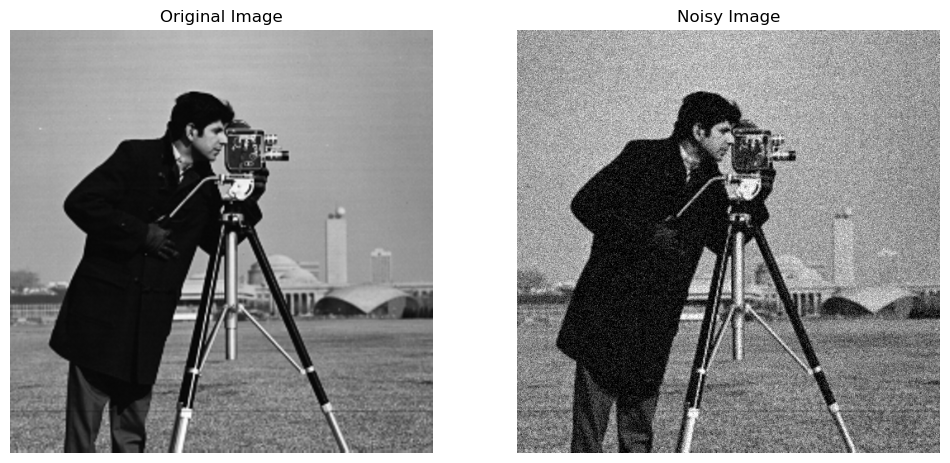

In [57]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,10))

axes[0].imshow(img, cmap='gray')
axes[0].axis('off')
axes[0].set_title("Original Image")

axes[1].imshow(noisy_img, cmap='gray')
axes[1].axis('off')
axes[1].set_title("Noisy Image")

In [58]:
coeffs = pywt.wavedec2(noisy_img, wavelet='db4', level=4)

In [59]:
N = noisy_img.size

# 2. Estimate noise standard deviation *once*
sigma_est = get_sigma_est(coeffs)
sigma_est

np.float64(0.09038743462906104)

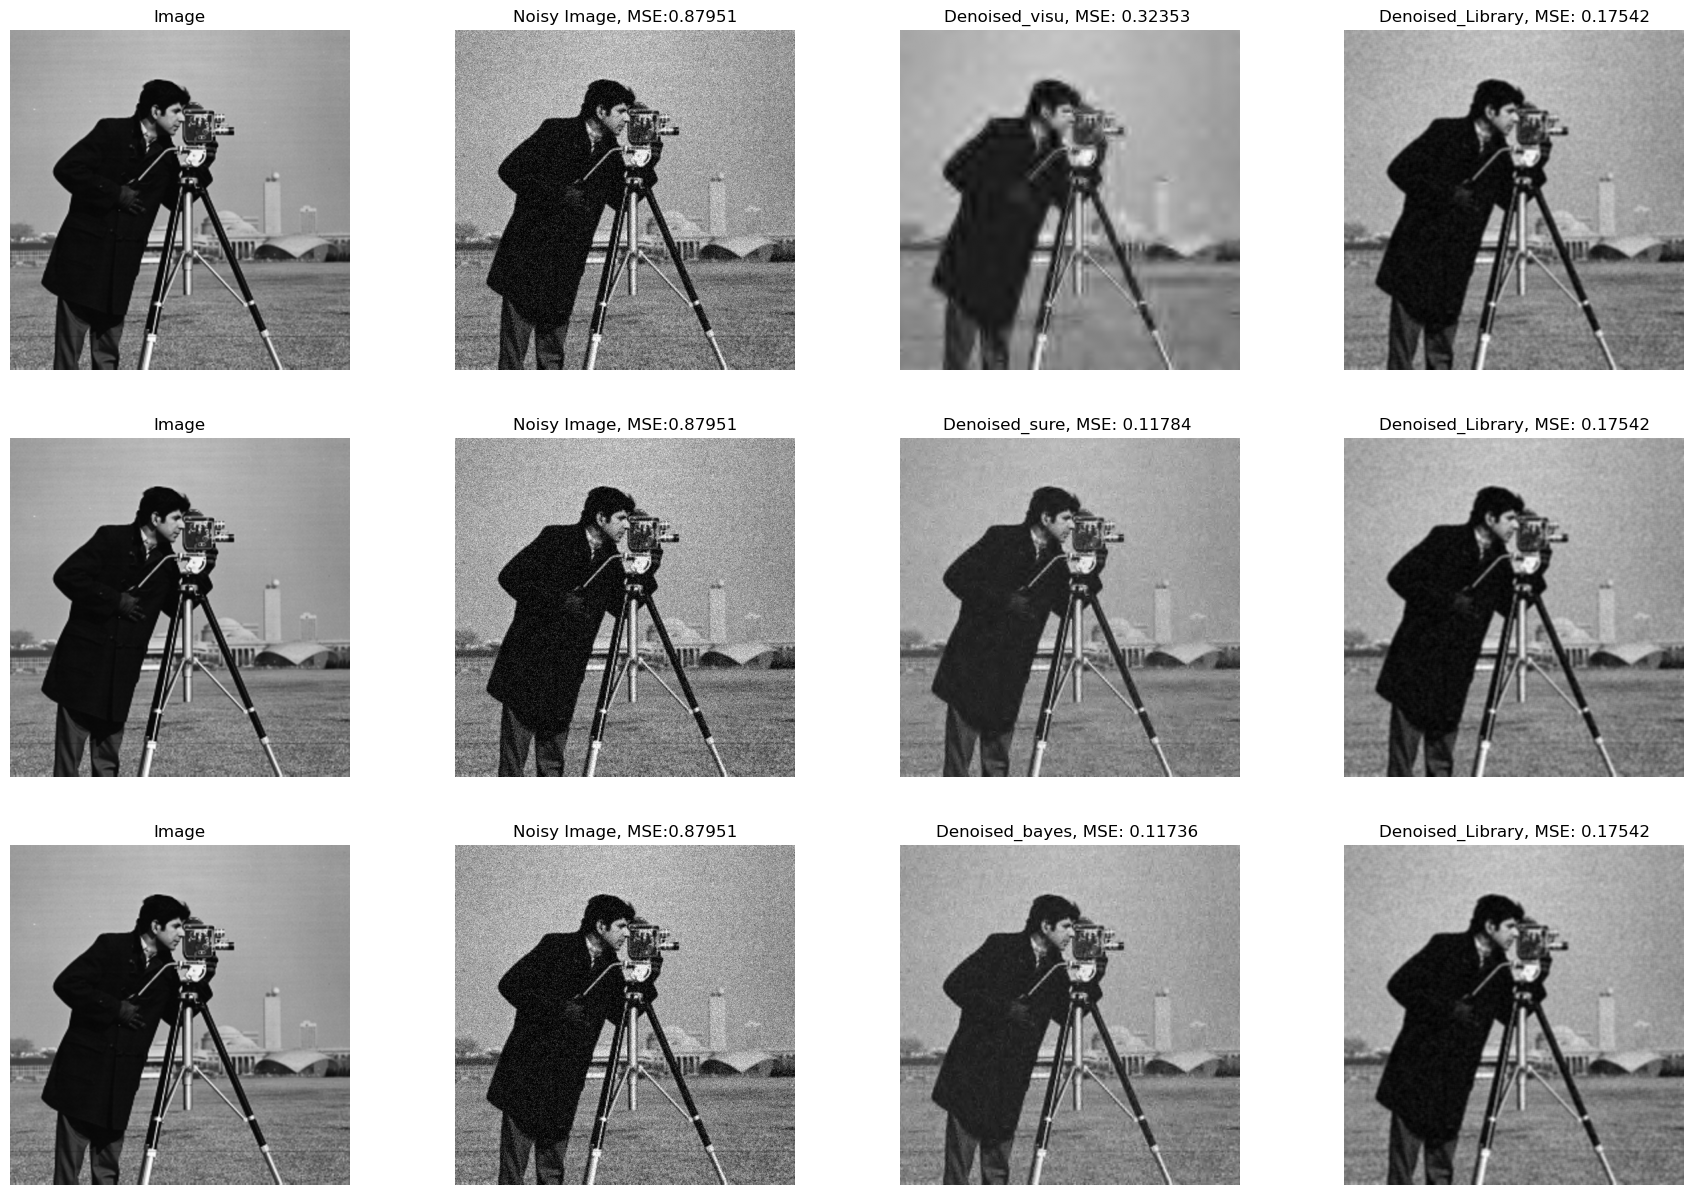

In [63]:
mode = ['visu', 'sure', 'bayes']
denoised_img_lib = gaussianSmoothing(noisy_img, 5, 15)
fig,axes = plt.subplots(nrows=len(mode), ncols=4, figsize=(22,15))

for i in range(len(mode)):
    thresholded_details = applyShrink(coeffs, sigma_est, N,  mode = mode[i])
    denoised_img = pywt.waverec2(thresholded_details, wavelet="db4")
    
    axes[i, 0].imshow(img_float, cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Image")

    axes[i, 1].imshow(noisy_img, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"""Noisy Image, MSE:{mse(img_float, noisy_img)*100:.5f}""")

    axes[i, 2].imshow(denoised_img, cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f"""Denoised_{mode[i]}, MSE: {mse(img_float, denoised_img)*100:.5f} """)

    axes[i, 3].imshow(denoised_img_lib, cmap='gray')
    axes[i, 3].axis('off')
    axes[i, 3].set_title(f"""Denoised_Library, MSE: {mse(img_float, denoised_img_lib)*100:.5f}""")


